In [1]:
import os,sys
import random
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as plt
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

In [2]:
### Enter the data folder name and WCR information

# select fold
fold_idx = 4

# Read folder path
path = os.getcwd()
train_path_upper = path + f'/data_mortar_IQR_split_FOLD_0{fold_idx}/train'
valid_path_upper = path + f'/data_mortar_IQR_split_FOLD_0{fold_idx}/valid'
test_path_upper = path + f'/data_mortar_IQR_split_FOLD_0{fold_idx}/test'

# WCR information
WC_name_tag = [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]

# Fit the random seed
seed_data = 4885
random.seed(seed_data)
np.random.seed(seed_data)
os.environ["PYTHONHASHSEED"] = str(seed_data)

In [3]:
### Data normalization

# Normalize to the minimum and maximum sensor measurement values.
def sense_min_max_Normalization(input_data, min_value, max_value):
    data = (input_data - min_value) / (max_value - min_value) 
    
    return data

def data_set_normalization(data):
    # sensor_min_value
    vwc_min = 0
    ec_min = 0
    salinity_min = 0
    tds_min = 0
    epsilon_min = 0
    temp_min = -40
    
    # sensor_max_value
    vwc_max = 100
    ec_max = 20000
    salinity_max = 20000
    tds_max = 20000
    temp_max = 80
    epsilon_max = 82
    
    # sensor_normalization 
    data['TEMP'] = sense_min_max_Normalization(data['TEMP'],temp_min,temp_max)
    data['EC'] = sense_min_max_Normalization(data['EC'],ec_min,ec_max)
    data['VWC'] = sense_min_max_Normalization(data['VWC'],vwc_min,vwc_max)
    data['TDS'] = sense_min_max_Normalization(data['TDS'],tds_min,tds_max)
    data['SALINITY'] = sense_min_max_Normalization(data['SALINITY'],salinity_min,salinity_max)
    data['EPSILON'] = sense_min_max_Normalization(data['EPSILON'],epsilon_min,epsilon_max)
    
    return data

In [4]:
### Load FDR Data for Train

path_list = []
path_under=os.listdir(train_path_upper)

# load data_path
for i in range(len(path_under)): # collect under directory file path
    path_sub=os.listdir(train_path_upper+'/'+path_under[i])
    
    for j in range(len(path_sub)):
        path_list.append(train_path_upper+'/'+path_under[i]+'/'+path_sub[j])

# make zero matrix
data_list = [0]*len(path_list)
rand_x_data_list = [0]*len(path_list)
rand_y_data_list = [0]*len(path_list)

# load data_value
for i,j in enumerate(path_list):
    data_list[i] =pd.read_csv(j)
    data_list[i] = data_set_normalization(data_list[i])
    
train_data = pd.concat(data_list)

# Print the data format
train_data

,WC_ratio,TEMP,EC,VWC,TDS,SALINITY,EPSILON
0,0.4,0.499583,0.18025,0.5965,0.09010,0.09910,0.657561
1,0.4,0.499750,0.18040,0.5976,0.09020,0.09920,0.659512
2,0.4,0.500417,0.18070,0.6014,0.09035,0.09935,0.665610
3,0.4,0.500417,0.18120,0.6027,0.09060,0.09965,0.667683
4,0.4,0.500667,0.18210,0.6052,0.09105,0.10015,0.671707
...,...,...,...,...,...,...,...
455,0.6,0.492417,0.28650,0.9488,0.14325,0.15755,0.967439
456,0.6,0.492667,0.28650,0.9488,0.14325,0.15755,0.967439
457,0.6,0.492667,0.28650,0.9488,0.14325,0.15755,0.967439
458,0.6,0.492417,0.28655,0.9488,0.14325,0.15760,0.967439


In [5]:
### Load FDR Data for Valid

valid_path_list = []
valid_path_under=os.listdir(valid_path_upper)

# load data_path
for i in range(len(valid_path_under)): # collect under directory file path
    valid_path_sub=os.listdir(valid_path_upper+'/'+valid_path_under[i])
    
    for j in range(len(valid_path_sub)):
        valid_path_list.append(valid_path_upper+'/'+valid_path_under[i]+'/'+valid_path_sub[j])

# make zero matrix
valid_data_list = [0]*len(valid_path_list)
valid_rand_x_data_list = [0]*len(valid_path_list)
valid_rand_y_data_list = [0]*len(valid_path_list)

# load data_value
for i,j in enumerate(valid_path_list):
    valid_data_list[i] =pd.read_csv(j)
    valid_data_list[i] = data_set_normalization(valid_data_list[i])
    
valid_data = pd.concat(valid_data_list)

# Print the data format
valid_data

,WC_ratio,TEMP,EC,VWC,TDS,SALINITY,EPSILON
0,0.4,0.514917,0.1924,0.6391,0.09620,0.10580,0.720488
1,0.4,0.514417,0.1958,0.6512,0.09790,0.10765,0.736098
2,0.4,0.514417,0.1960,0.6549,0.09800,0.10780,0.740610
3,0.4,0.514250,0.1963,0.6568,0.09815,0.10795,0.742927
4,0.4,0.513833,0.1966,0.6587,0.09830,0.10810,0.745244
...,...,...,...,...,...,...,...
506,0.6,0.504167,0.2778,0.8948,0.13890,0.15275,0.937439
507,0.6,0.504167,0.2778,0.8948,0.13890,0.15275,0.937439
508,0.6,0.504167,0.2778,0.8948,0.13890,0.15275,0.937439
509,0.6,0.504167,0.2778,0.8948,0.13890,0.15275,0.937439


In [6]:
### Load FDR Data for Test

test_path_list = []
test_path_under=os.listdir(test_path_upper)

# load data_path
for i in range(len(test_path_under)): # collect under directory file path
    test_path_sub=os.listdir(test_path_upper+'/'+test_path_under[i])
    
    for j in range(len(test_path_sub)):
        test_path_list.append(test_path_upper+'/'+test_path_under[i]+'/'+test_path_sub[j])

# make zero matrix
test_data_list = [0]*len(test_path_list)
test_rand_x_data_list = [0]*len(test_path_list)
test_rand_y_data_list = [0]*len(test_path_list)

# load data_value
for i,j in enumerate(test_path_list):
    test_data_list[i] =pd.read_csv(j)
    test_data_list[i] = data_set_normalization(test_data_list[i])
    
test_data = pd.concat(test_data_list)

# Print the data format
test_data

,WC_ratio,TEMP,EC,VWC,TDS,SALINITY,EPSILON
0,0.4,0.491500,0.15550,0.5570,0.07775,0.08550,0.585610
1,0.4,0.491500,0.15625,0.5588,0.07810,0.08590,0.589146
2,0.4,0.491083,0.15690,0.5597,0.07845,0.08625,0.590976
3,0.4,0.490833,0.15750,0.5597,0.07875,0.08660,0.590976
4,0.4,0.490833,0.15805,0.5597,0.07900,0.08690,0.590976
...,...,...,...,...,...,...,...
513,0.6,0.487667,0.29310,0.9488,0.14655,0.16120,0.967439
514,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439
515,0.6,0.487667,0.29400,0.9488,0.14700,0.16170,0.967439
516,0.6,0.487667,0.29355,0.9488,0.14675,0.16145,0.967439


In [7]:
# GT-label (WCR)
y_R = round(train_data['WC_ratio']*100, 1)
y_train = y_R.to_numpy()

# FDR sensor data
x_R = train_data[['TEMP','VWC','EPSILON','SALINITY','TDS','EC']]
x_train = x_R.to_numpy()

x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train, random_state=seed_data)

In [8]:
# GT-label (WCR)
y_R_valid = round(valid_data['WC_ratio']*100, 1)
y_valid = y_R_valid.to_numpy()

# FDR sensor data
x_R_valid = valid_data[['TEMP','VWC','EPSILON','SALINITY','TDS','EC']]
x_valid = x_R_valid.to_numpy()

x_valid_shuffled, y_valid_shuffled = shuffle(x_valid, y_valid, random_state=seed_data)

In [9]:
# GT-label (WCR)
y_R_test = round(test_data['WC_ratio']*100, 1)
y_test = y_R_test.to_numpy()

# FDR sensor data
x_R_test = test_data[['TEMP','VWC','EPSILON','SALINITY','TDS','EC']]
x_test = x_R_test.to_numpy()

x_test_shuffled, y_test_shuffled = shuffle(x_test, y_test, random_state=seed_data)

In [10]:
### Train OLS

model_0 = sm.OLS(y_train_shuffled, x_train_shuffled)
result_0 = model_0.fit()
print(result_0.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.218e+06
Date:                Fri, 06 Dec 2024   Prob (F-statistic):                        0.00
Time:                        15:46:02   Log-Likelihood:                         -28740.
No. Observations:               13207   AIC:                                  5.749e+04
Df Residuals:                   13201   BIC:                                  5.754e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [11]:
### Print the prediction results

p_result_0 = result_0.predict(x_test_shuffled)

p_result_0

array([50.30570745, 60.9250662 , 41.44041068, ..., 43.3463278 ,
       59.37195183, 45.16815868])

In [12]:
### print RMSE and R2-score

rmse_0 = round(mean_squared_error(y_test_shuffled, p_result_0, squared=False), 4)
r2_0 = round(r2_score(y_test_shuffled, p_result_0), 4)

print(f"RMSE : {rmse_0}")
print(f"r2_score : {r2_0}")

RMSE : 1.5777
r2_score : 0.9426


In [13]:
### Preprocess the results (group by the same y-value).

p_list_0 = [[]for i in range(len(WC_name_tag))]

for i,test_water in enumerate(y_test_shuffled):    
    for j,wc_name in enumerate(WC_name_tag):
        if i==len(y_test_shuffled):
            break
        if(np.round(test_water,3)==wc_name):
            p_list_0[j].append(p_result_0[i])
            
p_list_0

[[40.75043438714031,
  40.893592952573236,
  38.03913131888033,
  39.67797411988719,
  38.738953650985536,
  41.63276755102056,
  40.5936183876413,
  39.77004783343786,
  37.263391129574536,
  37.408193222966105,
  37.78192892853494,
  40.34221393117733,
  40.55082014681965,
  38.694717361587195,
  38.47222763427987,
  37.36437487117677,
  38.346333253015565,
  41.747903763868806,
  38.43043706641439,
  38.14824909387657,
  38.12166047694222,
  40.22697234779945,
  40.46889050876224,
  37.23019458881447,
  38.41884647000455,
  41.142401946611855,
  36.97478376047215,
  39.194912059701025,
  37.153881249183215,
  38.30212023023251,
  38.0774474541591,
  41.140456930662666,
  38.48377279689941,
  40.57266746964716,
  38.455716747588504,
  38.63417352341073,
  37.99705975967741,
  40.33307081071191,
  38.43043706641439,
  38.40731197307888,
  40.1956354238949,
  40.61572489903277,
  37.31325206503605,
  37.122618027831365,
  40.757027852074216,
  38.5636632838899,
  39.39738338653016,
  3

In [14]:
### Print the mean and standard deviation of the predicted WCR (Water-Cement Ratio).

p_list_mean = [[]for i in range(len(WC_name_tag))]
p_list_std = [[]for i in range(len(WC_name_tag))]

for i in range(len(WC_name_tag)):
    tmp_mean = np.mean(p_list_0[i])
    tmp_std = np.std(p_list_0[i])
    
    p_list_mean[i].append(tmp_mean)
    p_list_std[i].append(tmp_std)

flattened_mean = [item for sublist in p_list_mean for item in sublist]
flattened_std = [item for sublist in p_list_std for item in sublist]

print(f"meanb per WCR: {flattened_mean}\n")
print(f"std per WCR: {flattened_std}")

meanb per WCR: [39.02019845227282, 43.750212413966906, 45.26139726911869, 47.361619349804165, 49.80019485119588, 52.22355946035692, 53.94804499486239, 56.580444626891484, 60.72094953993545]

std per WCR: [1.5386648168519421, 2.208841546654711, 1.3797110813962756, 1.4673494456332306, 0.9864560134272097, 1.4887686842883863, 0.5213569681583881, 1.137658183668031, 0.7913013117884499]


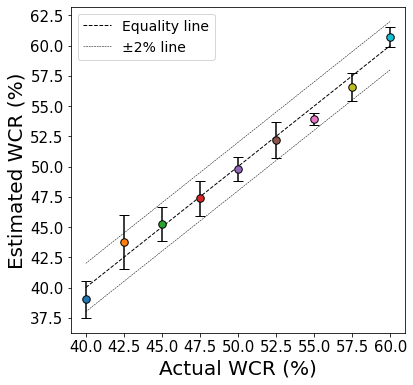

In [15]:
### Plot graph

x_axis = [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]
y_axis = [37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(figsize=(6, 6))

for i, tmp_color in enumerate(colors):
    ax.errorbar(WC_name_tag[i], flattened_mean[i], yerr=flattened_std[i], linestyle='None', markeredgecolor='k', ecolor='k', marker='o', markersize=7.5, color=tmp_color, capsize=5, elinewidth=1.5)

# equal line
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], c='k', ls='--', lw=1, label='Equality line')

# upper line
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [42, 44.5, 47, 49.5, 52, 54.5, 57, 59.5, 62], c='k', ls='--', lw=0.5, label='±2% line')

# under lone
plt.plot([40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], [38, 40.5, 43, 45.5, 48, 50.5, 53, 55.5, 58], c='k', ls='--', lw=0.5)

plt.xlabel('Actual WCR (%)', fontdict={'size': 20})
plt.ylabel('Estimated WCR (%)', fontdict={'size': 20})
plt.xticks(x_axis, fontsize=15)
plt.yticks(y_axis, fontsize=15)
plt.legend(fontsize=14)

plt.show()